### Import packages

In [416]:
import sys
sys.path
sys.path.append("/anaconda3/envs/metis/lib/python3.7/site-packages")

%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append("/anaconda3/envs/metis/lib/python3.6/site-packages")
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from mlxtend.plotting import plot_decision_regions #plotting regions

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


### Read and clean data

In [210]:
df_2017 = pd.read_csv('usa_00006.csv')

In [282]:
df_2017.columns

Index(['YEAR', 'DATANUM', 'SERIAL', 'CBSERIAL', 'HHWT', 'STATEFIP', 'METRO',
       'CITY', 'GQ', 'OWNERSHP', 'OWNERSHPD', 'PERNUM', 'PERWT', 'NCHILD',
       'SEX', 'AGE', 'MARST', 'BPL', 'BPLD', 'HCOVANY', 'EDUC', 'EDUCD',
       'EMPSTAT', 'EMPSTATD', 'OCC', 'IND', 'POVERTY', 'MIGRATE1',
       'MIGRATE1D'],
      dtype='object')

In [394]:
# Filter for California adults only:
# df_CA = df_2017.loc[(df_2017.STATEFIP == 6) & (df_2017.AGE >= 18),:].copy()
df_CA = df_2017.loc[(df_2017.AGE >= 18),:].copy()

# Generate unique identifier for each person
df_CA['UNIQUE_ID'] = df_CA['YEAR'].map(str) + df_CA['DATANUM'].map(str) + \
                     df_CA['SERIAL'].map(str) + df_CA['PERNUM'].map(str)

# Set poverty binary (less than 100% of poverty level is 1)
df_CA['POVERTY_BIN'] = np.where(df_CA['POVERTY'] <= 100, 1,0)

# Keep only relevant columns
model_cols = ['UNIQUE_ID', 'PERWT', 'POVERTY_BIN', 'AGE', 'MIGRATE1', 'NCHILD', 'BPL', \
              'EDUC', 'MARST', 'EMPSTAT', 'SEX', 'HCOVANY']

df_CA_M = df_CA[model_cols].copy()

# Set 0's to nulls
null_cols = ['MIGRATE1', 'EDUC', 'EMPSTAT']

df_CA_M.loc[:, null_cols] = df_CA_M.loc[:, null_cols].replace({0:np.nan})

# Drop nulls
df_CA_M = df_CA_M.dropna()

In [395]:
print('Original shape:', df_CA.shape)
print('Post clean shape:', df_CA_M.shape)

Original shape: (2530726, 31)
Post clean shape: (2494864, 12)


In [396]:
# Generate international migration binary
df_CA_M['MIGRATE_BIN'] = np.where(df_CA_M['MIGRATE1'] == 4, 1,0)

# Generate born within the US binary
df_CA_M['BPL_BIN'] = np.where(df_CA_M['BPL'] <= 120, 1,0)

# Generate marriage binary (currently married = 1, not ever married or divorced = 0)
df_CA_M['MARST_BIN'] = np.where(df_CA_M['MARST'] <= 2, 1,0)

# Generate education bins (middle school only, high school only, 4 years college, 4+ years college)
educ_bins = [0, 2, 6, 10, 11]
educ_labels = ['LOW_ED', 'HIGH_SCH_ED', 'UNDERGRAD_ED', 'GRAD_ED']

df_CA_M['EDUC_CAT'] = pd.cut(df_CA_M['EDUC'], bins, labels = educ_labels, include_lowest = True)

# Generate employment bins
df_CA_M.loc[df_CA_M['EMPSTAT'] == 1, 'EMPSTAT'] = 'EMPLOYED'
df_CA_M.loc[df_CA_M['EMPSTAT'] == 2, 'EMPSTAT'] = 'UNEMPLOYED'
df_CA_M.loc[df_CA_M['EMPSTAT'] == 3, 'EMPSTAT'] = 'N_LABOR'

# Generate gender binary
df_CA_M['SEX'] = np.where(df_CA_M['SEX'] == 2, 'MALE', 'FEMALE')

# Generate health coverage binary
df_CA_M['HCOVANY'] = np.where(df_CA_M['HCOVANY'] == 2, 1, 0)

df_CA_M = pd.get_dummies(df_CA_M, columns = ['EDUC_CAT', 'EMPSTAT', 'SEX'], drop_first = True)

In [397]:
df_CA_M.columns

Index(['UNIQUE_ID', 'PERWT', 'POVERTY_BIN', 'AGE', 'MIGRATE1', 'NCHILD', 'BPL',
       'EDUC', 'MARST', 'HCOVANY', 'MIGRATE_BIN', 'BPL_BIN', 'MARST_BIN',
       'EDUC_CAT_HIGH_SCH_ED', 'EDUC_CAT_UNDERGRAD_ED', 'EDUC_CAT_GRAD_ED',
       'EMPSTAT_N_LABOR', 'EMPSTAT_UNEMPLOYED', 'SEX_MALE'],
      dtype='object')

0    0.848712
1    0.151288
Name: POVERTY_BIN, dtype: float64


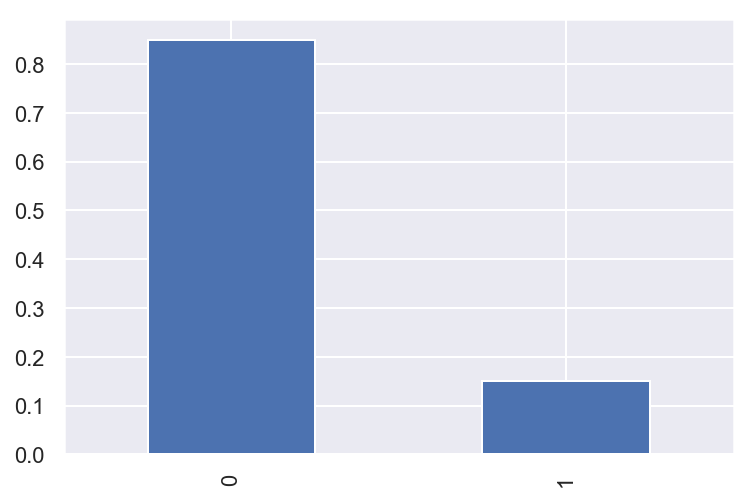

In [398]:
# Visualize % in poverty for overall data
target_pcts = df_CA_M['POVERTY_BIN'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

0    0.846682
1    0.153318
Name: POVERTY_BIN, dtype: float64


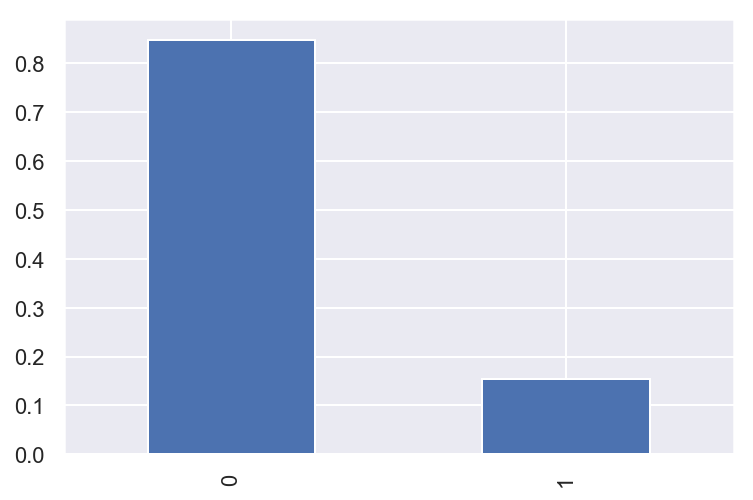

In [399]:
# Visualize % in poverty for overall data
target_pcts = df_CA['POVERTY_BIN'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


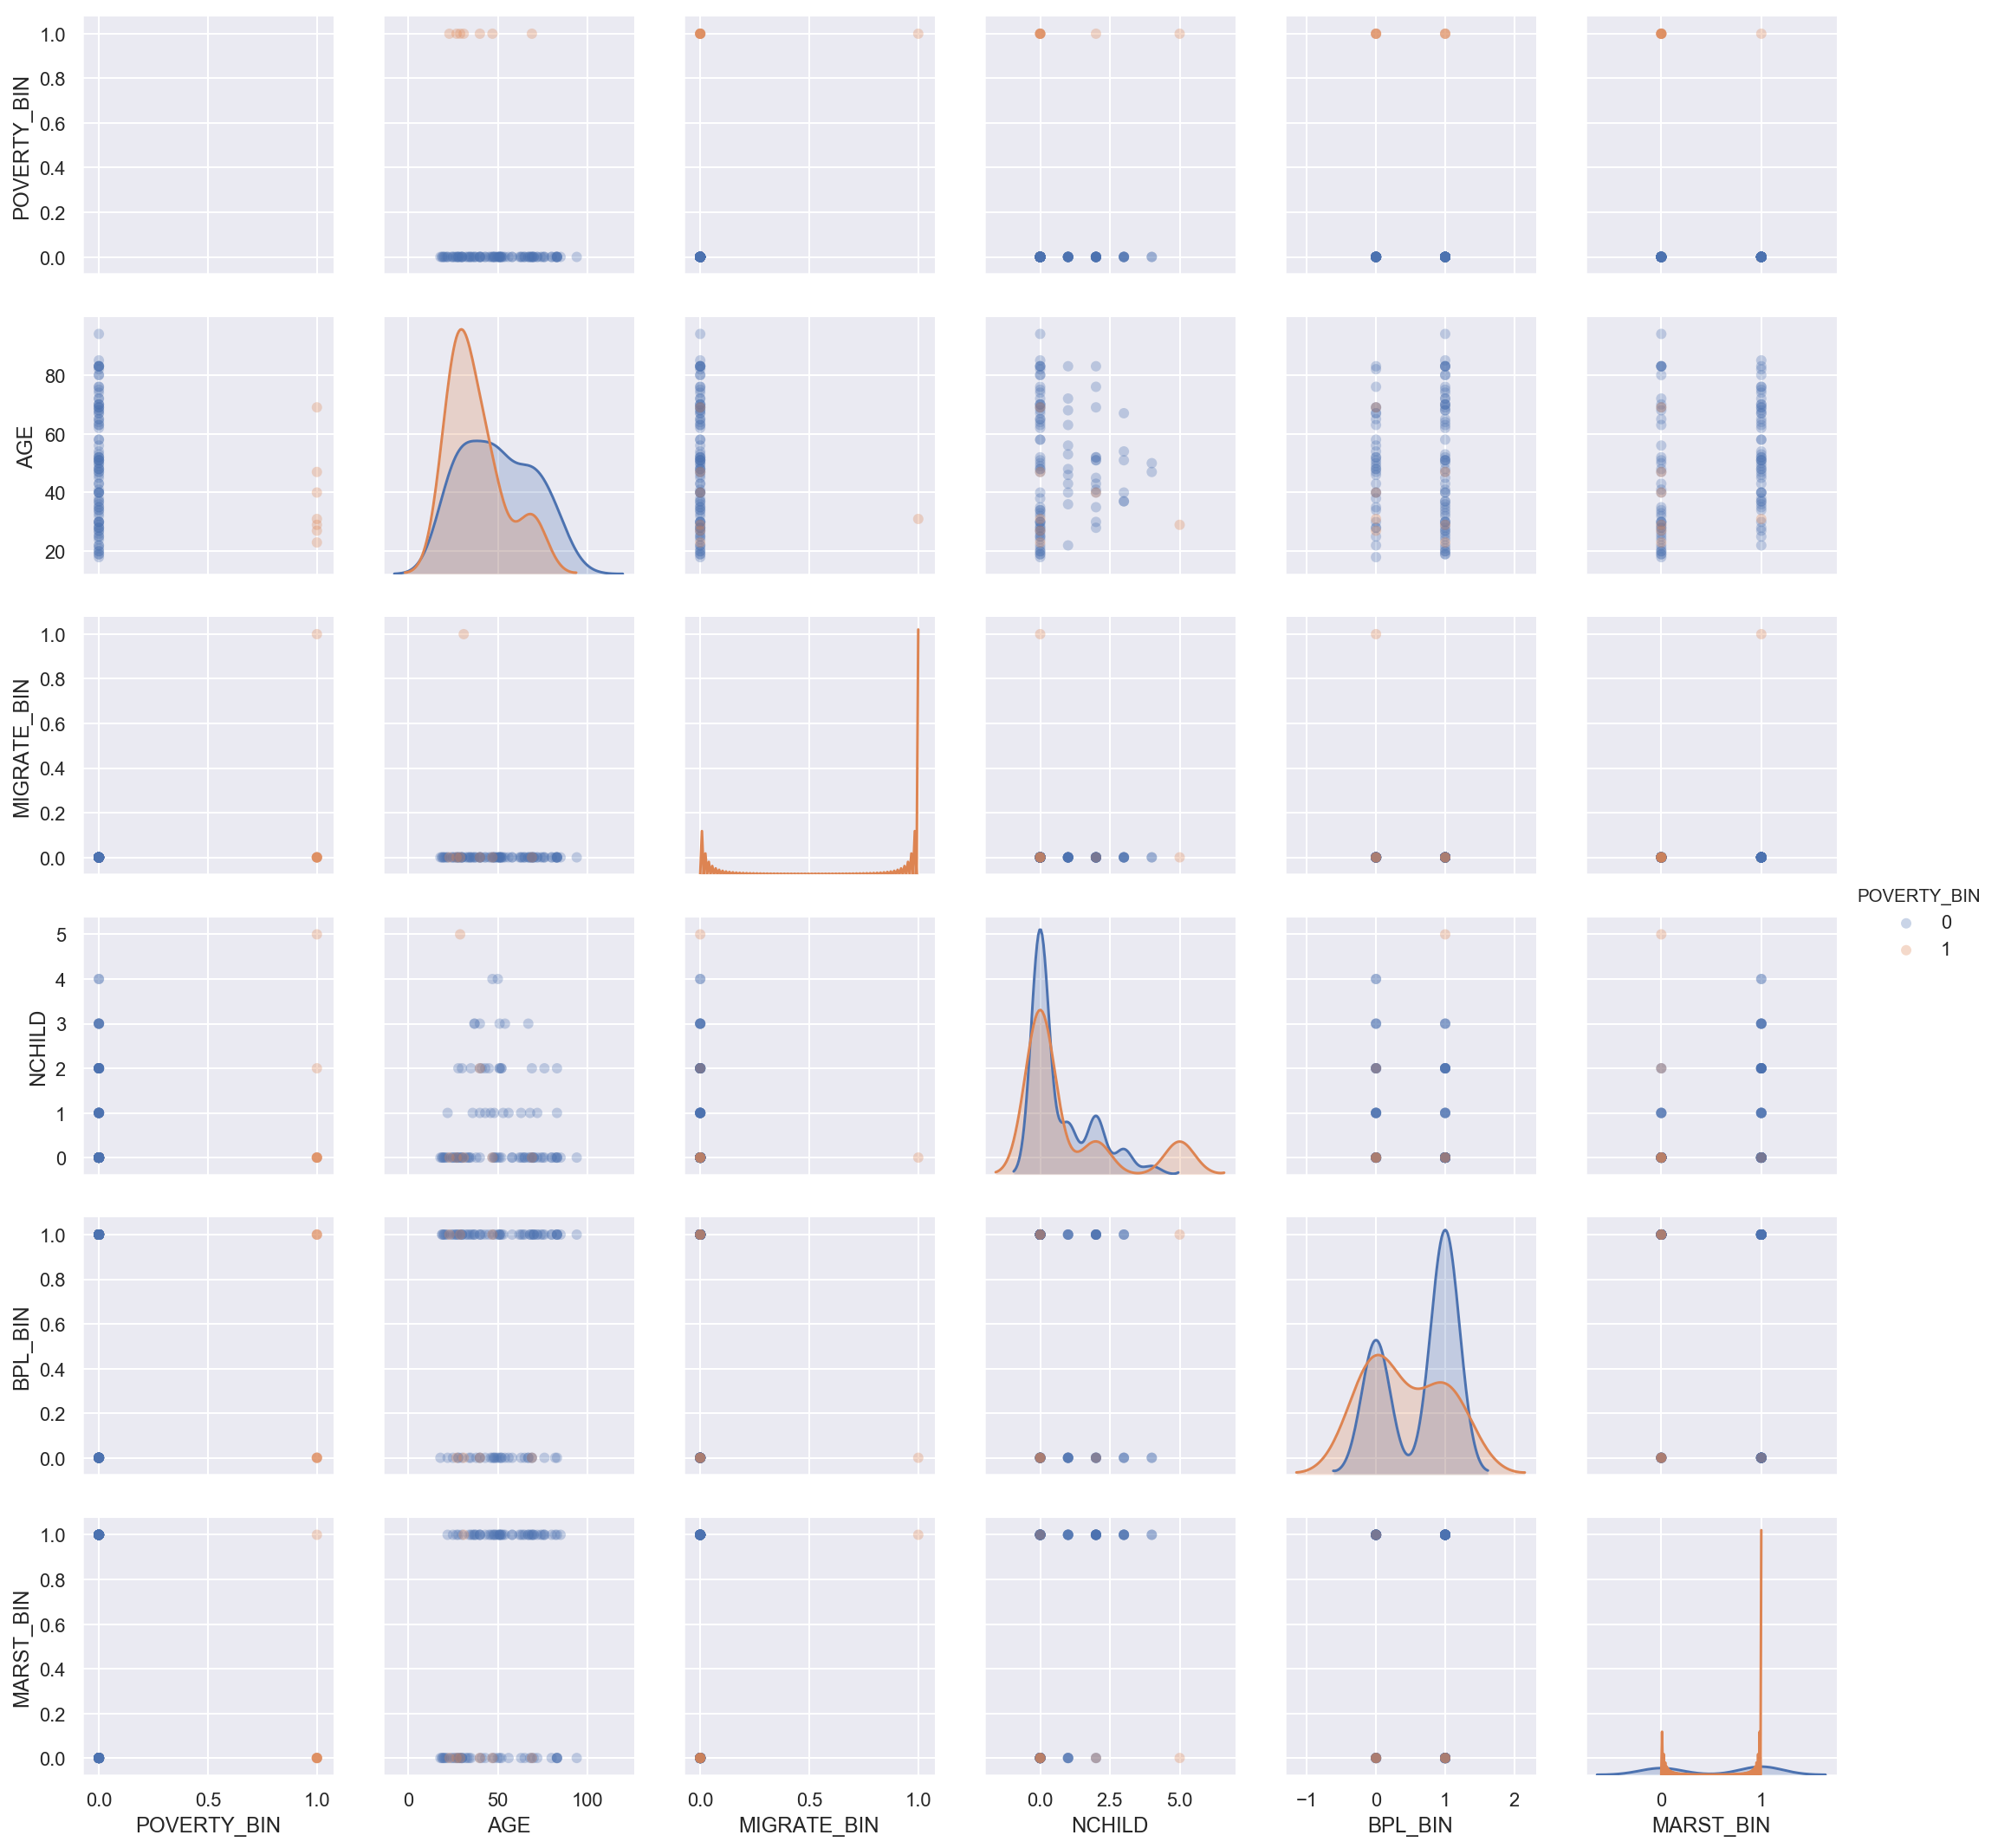

In [322]:
plot_cols = ['POVERTY_BIN', 'AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', \
             'MARST_BIN']

def plot_features(df, sample_size=500):
    
    sample = (df[plot_cols]
                .sample(100, random_state=20)) 
    
    sns.pairplot(sample,hue='POVERTY_BIN', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_CA_M)

### Testing Helper Functions

In [379]:
def scores(model, X_te, y_te, threshold):
    prediction = model.predict_proba(X_te)[:,1] > threshold 
    print(classification_report(y_te, prediction, digits = 4))

In [386]:
def print_ROC_curve(model, X_te, y_te):
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te)[:,1])
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model} model');
    print("ROC AUC score = ", roc_auc_score(y_te, model.predict_proba(X_te)[:,1]))

In [357]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,5), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Test Split Data

In [400]:
X = df_CA_M[['AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', 'MARST_BIN', \
             'EDUC_CAT_HIGH_SCH_ED', 'EDUC_CAT_UNDERGRAD_ED', 'EDUC_CAT_GRAD_ED', 'PERWT', \
             'EMPSTAT_N_LABOR', 'EMPSTAT_UNEMPLOYED', 'SEX_MALE', 'HCOVANY']]
y = df_CA_M[['POVERTY_BIN']]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

WT_tr = X_tr[['PERWT']].copy()
WT_te = X_te[['PERWT']].copy()

X_tr = X_tr.drop(columns = ['PERWT'])
X_te = X_te.drop(columns = ['PERWT'])

### Logistic Regression

In [401]:
lr = LogisticRegression(solver='lbfgs', max_iter = 500, class_weight = 'balanced', random_state = 42)
lr_fit = lr.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())

In [402]:
scores(lr, X_te, y_te, 0.5)

              precision    recall  f1-score   support

           0     0.9397    0.7869    0.8566    423484
           1     0.3749    0.7167    0.4923     75489

   micro avg     0.7763    0.7763    0.7763    498973
   macro avg     0.6573    0.7518    0.6744    498973
weighted avg     0.8542    0.7763    0.8014    498973



In [403]:
scores(lr, X_te, y_te, .8)

              precision    recall  f1-score   support

           0     0.8883    0.9561    0.9210    423484
           1     0.5695    0.3257    0.4144     75489

   micro avg     0.8607    0.8607    0.8607    498973
   macro avg     0.7289    0.6409    0.6677    498973
weighted avg     0.8401    0.8607    0.8443    498973



In [404]:
lr.coef_

array([[-0.02461991,  0.83435846,  0.1893081 , -0.2097377 , -1.47613859,
        -0.57626856, -0.99461269, -1.62294557,  1.97061742,  1.53668122,
         0.0848511 , -0.69566214]])

In [405]:
list(X_tr.columns)

['AGE',
 'MIGRATE_BIN',
 'NCHILD',
 'BPL_BIN',
 'MARST_BIN',
 'EDUC_CAT_HIGH_SCH_ED',
 'EDUC_CAT_UNDERGRAD_ED',
 'EDUC_CAT_GRAD_ED',
 'EMPSTAT_N_LABOR',
 'EMPSTAT_UNEMPLOYED',
 'SEX_MALE',
 'HCOVANY']

ROC AUC score =  0.8337367310193314


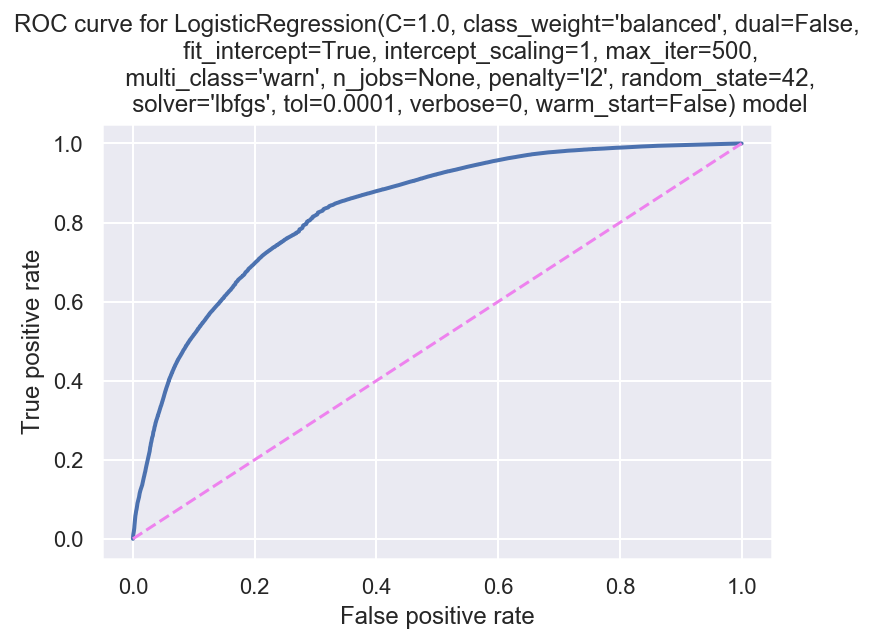

In [407]:
print_ROC_curve(lr, X_te, y_te)

### Logistic Regression CV

In [413]:
lrCV = LogisticRegressionCV(solver='lbfgs', max_iter = 500, class_weight = 'balanced', cv = 5, random_state = 42)
lrCV_fit = lrCV.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())

In [414]:
scores(lrCV, X_te, y_te, 0.5)

              precision    recall  f1-score   support

           0     0.9397    0.7870    0.8566    423484
           1     0.3748    0.7165    0.4922     75489

   micro avg     0.7763    0.7763    0.7763    498973
   macro avg     0.6572    0.7517    0.6744    498973
weighted avg     0.8542    0.7763    0.8014    498973



ROC AUC score =  0.8337362278033991


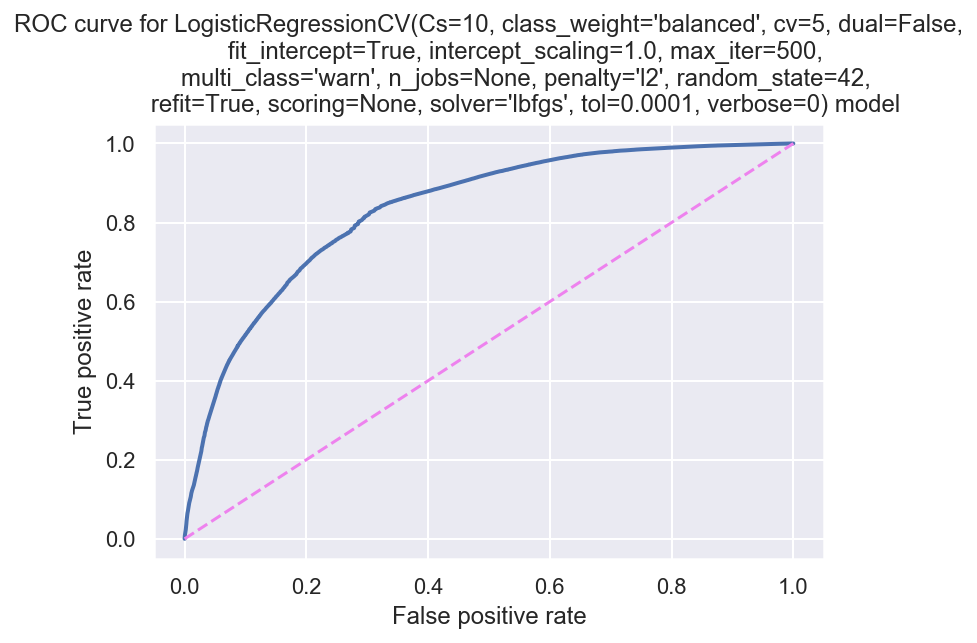

In [415]:
print_ROC_curve(lrCV, X_te, y_te)

### Random Forest

In [408]:
randomforest = RandomForestClassifier(n_estimators=100, n_jobs = -1, class_weight = 'balanced', random_state = 42)
randomforest.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [409]:
scores(randomforest, X_te, y_te, 0.5)

              precision    recall  f1-score   support

           0     0.9461    0.8065    0.8707    423484
           1     0.4060    0.7421    0.5248     75489

   micro avg     0.7967    0.7967    0.7967    498973
   macro avg     0.6760    0.7743    0.6978    498973
weighted avg     0.8644    0.7967    0.8184    498973



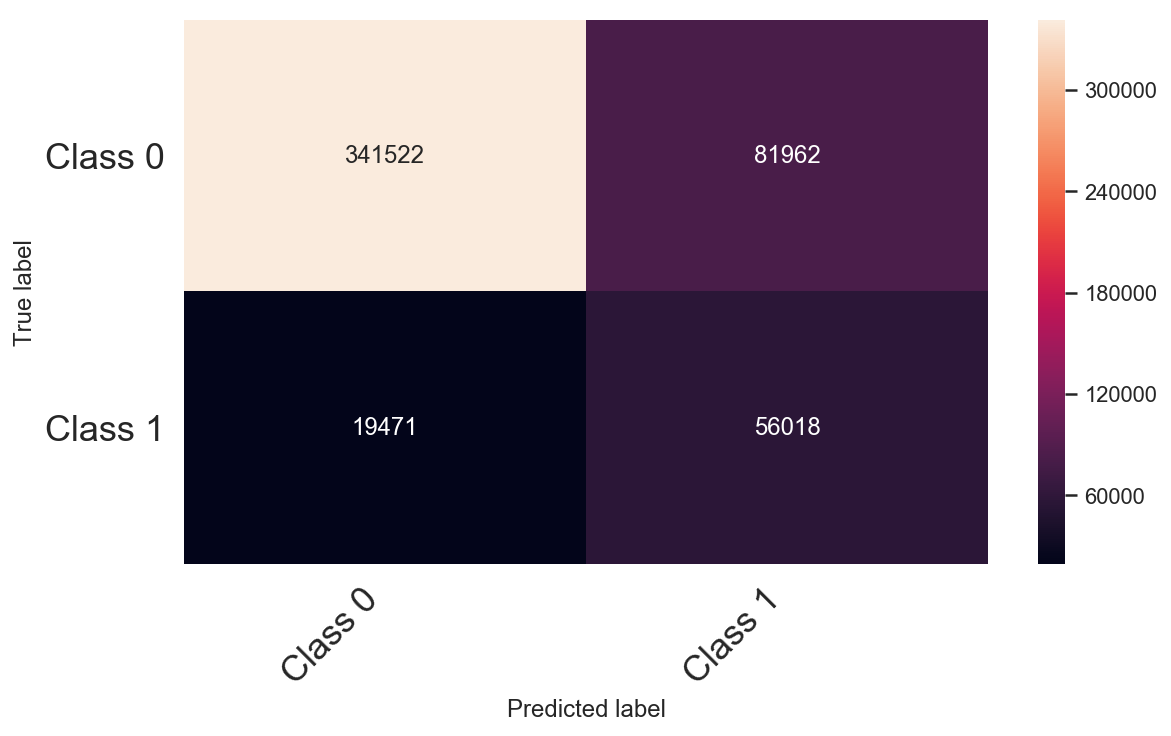

In [410]:
y_pred = randomforest.predict(X_te)
conf_mat = confusion_matrix(y_true=y_te, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

ROC AUC score =  0.8447839493141098


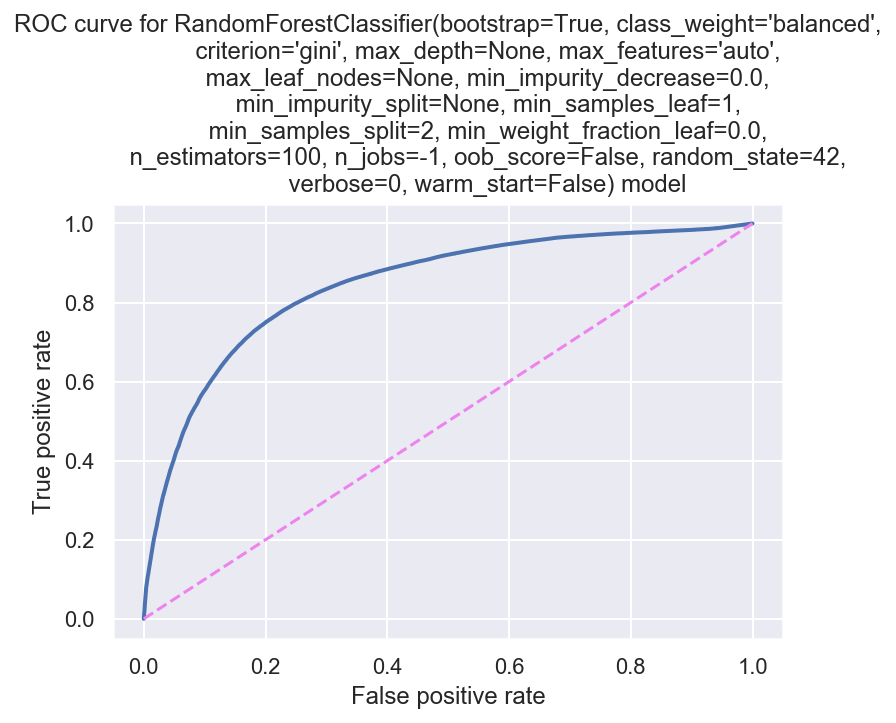

In [411]:
print_ROC_curve(randomforest, X_te, y_te)

### SVC Model

In [ ]:
svm_model = svm.SVC(kernel="linear", class_weight = 'balanced')
svm_model.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())